Вариант 21

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

In [68]:
df = pd.read_excel('./data6/Volgmed_2013.xlsx', skiprows=1)[['Пол', 'Рост, см']]
df = df[((df['Пол'] == 'жен') | (df['Пол'] == 'жен.')) & (df['Рост, см'].isnull() != True) & (df['Рост, см'] != 'освобобожденная') & (df['Рост, см'] != 'освобождена от сдачи нормативов') & (df['Рост, см'] != 'спец. Группа') & (df['Рост, см'] != 'освобождена')]
df

,Пол,"Рост, см"
0,жен,176
1,жен,176
8,жен,166
9,жен,166
10,жен,166
...,...,...
4213,жен,167.5
4214,жен,170
4215,жен,161.5
4216,жен,170


In [69]:
data = df['Рост, см'].to_numpy()
q_025 = np.quantile(data, 0.25)
q_075 = np.quantile(data, 0.75)
iqd = q_075 - q_025
upper_threshold = q_075 + 1.5 * iqd
lower_threshold = q_025 - 1.5 * iqd

df_clean = df.loc[(df['Рост, см'] <= upper_threshold) & (df['Рост, см'] >= lower_threshold)]
data = df_clean['Рост, см'].to_numpy()

Approximation with 1 Gaussian distribution:
Gaussian 1: mu = 165.411, sigma = 6.29, weight = 1.0
Approximation with 2 Gaussian distributions:
Gaussian 1: mu = 162.64, sigma = 5.436, weight = 0.574
Gaussian 2: mu = 169.138, sigma = 5.368, weight = 0.426
Approximation with 3 Gaussian distributions:
Gaussian 1: mu = 160.118, sigma = 4.539, weight = 0.389
Gaussian 2: mu = 167.041, sigma = 3.42, weight = 0.464
Gaussian 3: mu = 174.31, sigma = 4.013, weight = 0.147
pvalue for 0-component mixture = 1.0
pvalue for 1-component mixture = 0.005961639019198095
pvalue for 2-component mixture = 0.11798882673247547
1-component mixture is accepted



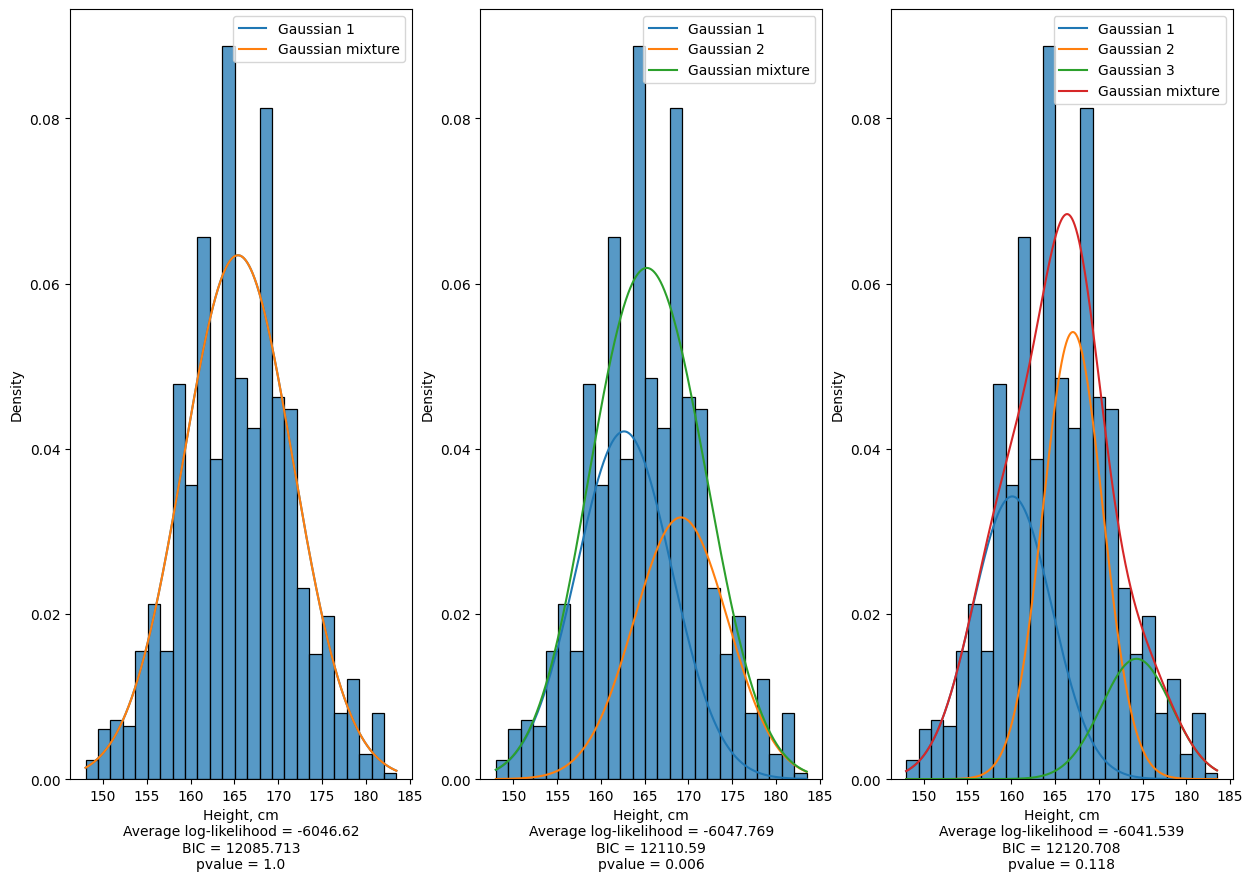

In [70]:
x = np.linspace(np.min(data), np.max(data), 2000)

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 10))
free_deg = np.zeros(3)
log_lhood = np.zeros(3)
bic = np.zeros(3)
for i in range(3):
    gmm = GaussianMixture(n_components = i + 1, tol = 0.0001)
    gmm.fit(np.expand_dims(data, 1))
    print(f'Approximation with {i + 1} Gaussian distribution{'s'if i+1 > 1 else ''}:')
    gaussian_count = 1
    for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
        print(f'Gaussian {gaussian_count}: mu = {round(mu, 3)}, sigma = {round(sd, 3)}, weight = {round(p, 3)}')
        pdf = stats.norm(mu, sd).pdf(x) * p
        ax[i].plot(x, pdf, label = f'Gaussian {gaussian_count}')
        gaussian_count += 1
    gmm_sum = np.exp([gmm.score_samples(e.reshape(-1, 1)) for e in x])
    free_deg[i] = (3 * i - 1)
    log_lhood[i] = len(data) * gmm.score(np.expand_dims(data, 1))
    bic[i] = free_deg[i] * np.log(len(data)) - 2 * log_lhood[i]
    
    ax[i].plot(x, gmm_sum, label = 'Gaussian mixture')
    sns.histplot(data = data, stat = 'density', ax = ax[i])
    ax[i].legend()

pvalues = np.zeros(3)
for i in range(3):
    pvalues[i] = stats.chi2.sf(2 * (log_lhood[bool(i) + 1] - log_lhood[i % 2]), free_deg[bool(i) + 1] - free_deg[i % 2])
    print(f'pvalue for {i}-component mixture = {pvalues[i]}')
    ax[i].set_xlabel(f'Height, cm\nAverage log-likelihood = {round(log_lhood[i], 3)}\nBIC = {round(bic[i], 3)}\npvalue = {round(pvalues[i], 3)}')
print(f'{np.argmax(pvalues) + 1}-component mixture {'are'if np.argmax(pvalues) > 0 else 'is'} accepted\n')
plt.show()

pvalue for the first half of the sample =  0.0693179007620906
pvalue for the second half of the sample =  0.02748392879599101
pvalue for the random half of the shuffled sample =  1.746021562820445e-05
pvalue for the random half of the shuffled sample =  0.012202530694793505


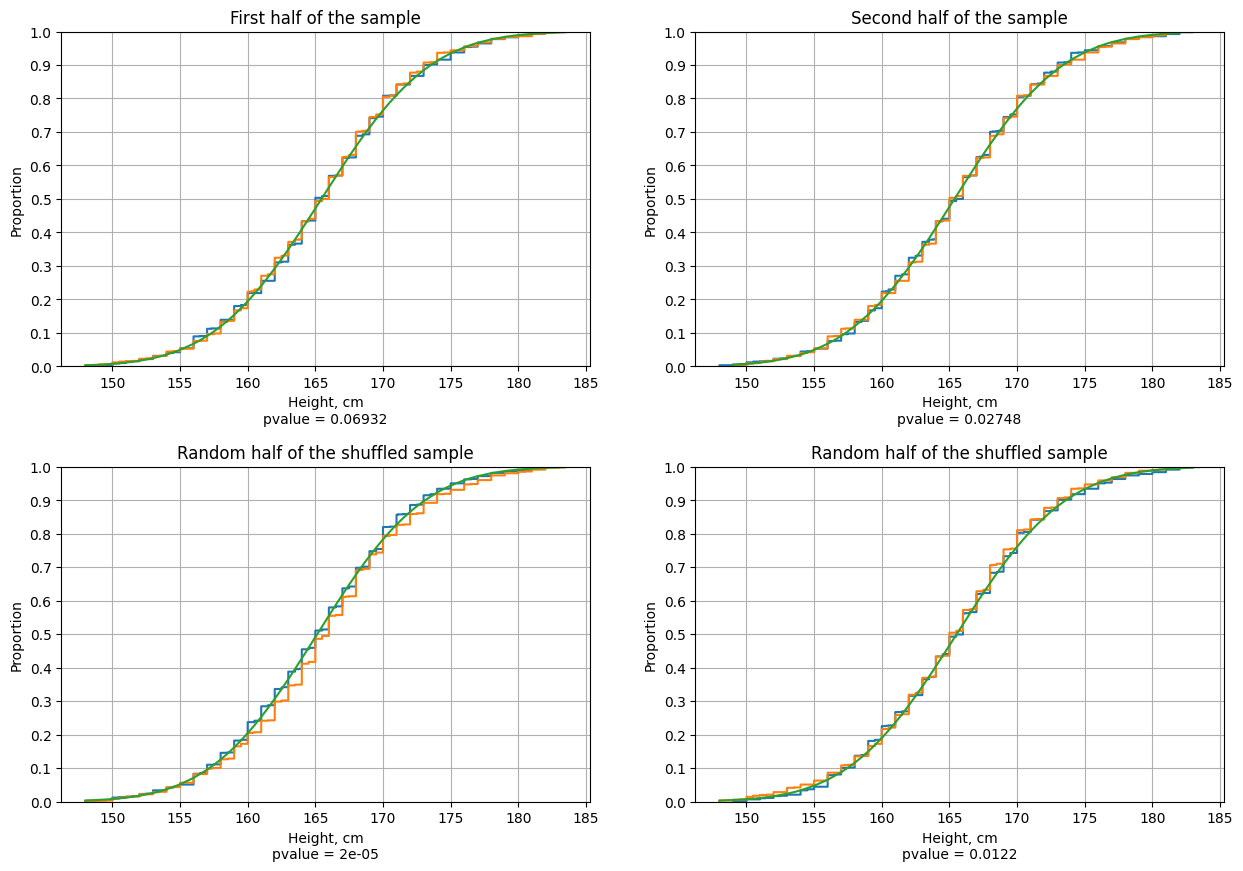

In [71]:
def ks1_asympt(cdf_data):
    n = len(cdf_data)
    cdf_data.sort()
    D_n = 0
    for i in range(n):
        if max(abs(cdf_data[i] - i / n), abs(cdf_data[i] - (i - 1) / n)) > D_n:
            D_n = max(abs(cdf_data[i] - i / n), abs(cdf_data[i] - (i - 1) / n))
    return stats.kstwobign.sf(n**0.5 * D_n)

def ksTest(data1, data2, iter):
    gmm = GaussianMixture(n_components = np.argmax(pvalues) + 1, tol = 0.0001)
    gmm.fit(np.expand_dims(data1, 1))
    cdf_data = np.zeros(len(data2))
    for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
        cdf_data += stats.norm(mu, sd).cdf(data2) * p
    
    pvalue = ks1_asympt(cdf_data)
    data2.sort()
    cdf_data.sort()

    sns.ecdfplot(data = data1, ax = ax[iter // 2][iter % 2])
    sns.ecdfplot(data = data2, ax = ax[iter // 2][iter % 2])
    ax[iter // 2][iter % 2].axes.set_yticks(np.arange(start = 0, stop = 1.1, step = 0.1))
    ax[iter // 2][iter % 2].grid()
    ax[iter // 2][iter % 2].plot(data2, cdf_data)
    ax[iter // 2][iter % 2].set_xlabel(f'Height, cm\npvalue = {round(pvalue, 5)}')
    if (iter == 0):
        print('pvalue for the first half of the sample = ', pvalue)
        ax[iter // 2][iter % 2].set_title('First half of the sample')
    elif (iter == 1):
        print('pvalue for the second half of the sample = ', pvalue)
        ax[iter // 2][iter % 2].set_title('Second half of the sample')
    else:
        print('pvalue for the random half of the shuffled sample = ', pvalue)
        ax[iter // 2][iter % 2].set_title('Random half of the shuffled sample')

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.subplots_adjust(hspace = 0.3)
for i in range(4):
    if (i == 2 or i == 3):
        np.random.shuffle(data)

    data_half1 = data[:round(len(data) / 2)].astype(float)
    data_half2 = data[round(len(data) / 2):].astype(float)

    if (i != 1):
        ksTest(data_half1, data_half2, i)
    else:
        ksTest(data_half2, data_half1, i)
        
plt.show()